In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import load
import imblearn

from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV, ElasticNet, SGDRegressor, BayesianRidge
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import VotingRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
    

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **Data**

Load data:

In [2]:
train = pd.read_csv("/kaggle/input/bizinnovate-2023/train.csv")
test = pd.read_csv("/kaggle/input/bizinnovate-2023/test_masked.csv")

low_train_mean = []
high_train_mean = []
print("Load Train Value")
for i in range(train.shape[0]):
    path = "/kaggle/input/bizinnovate-2023/dhs_train/" + train["DHSID_EA"][i] + ".npz"
    data = load(path)
    lst = data.files
    for item in lst:
        array = data[item].reshape(-1)
    df = pd.DataFrame(array)

    low = df[df < 150]
    low_mean = low.mean()
    
    low_train_mean = np.append(low_train_mean, low_mean)
    
    high = df[df > 150]
    high_mean = high.mean()
    
    high_train_mean = np.append(high_train_mean, high_mean)
    
    if (i % 1000 == 0):
        print((i*100/train.shape[0]), "%")
    
train["image_mean_low"] = low_train_mean
train["image_mean_high"] = high_train_mean


low_test_mean = []
high_test_mean = []
print("Load Test Value")
for i in range(test.shape[0]):
    path = "/kaggle/input/bizinnovate-2023/dhs_test/" + test["DHSID_EA"][i] + ".npz"
    data = load(path)
    lst = data.files
    for item in lst:
        array = data[item].reshape(-1)
    df = pd.DataFrame(array)
    
    low = df[df < 150]
    low_mean = low.mean()
    
    low_test_mean = np.append(low_test_mean, low_mean)
    
    high = df[df > 150]
    high_mean = high.mean()
    
    high_test_mean = np.append(high_test_mean, high_mean)
    
    if (i % 1000 == 0):
        print((i*100/test.shape[0]), "%")
        
test["image_mean_low"] = low_test_mean
test["image_mean_high"] = high_test_mean

print(train.shape)
print(test.shape)
train.head()

Load Train Value
0.0 %
5.341309689135776 %
10.682619378271552 %
16.023929067407327 %
21.365238756543103 %
26.70654844567888 %
32.04785813481465 %
37.38916782395043 %
42.73047751308621 %
48.071787202221984 %
53.41309689135776 %
58.75440658049354 %
64.0957162696293 %
69.43702595876509 %
74.77833564790086 %
80.11964533703664 %
85.46095502617241 %
90.8022647153082 %
96.14357440444397 %
Load Test Value
0.0 %
37.38317757009346 %
74.76635514018692 %
(18722, 15)
(2675, 13)


,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,cluster_id,adm1dhs,urban,path,image_mean_low,image_mean_high
0,IA-2015-7-00010004,IA,2015,9.165413,92.742696,22.0,2.650768,22.0,5.000000,10004,1,R,dhs_train/IA-2015-7-00010004.npz,0.102477,295.839325
1,IA-2015-7-00010005,IA,2015,8.307356,93.093792,22.0,2.157784,22.0,5.000000,10005,1,R,dhs_train/IA-2015-7-00010005.npz,0.077350,295.188934
2,IA-2015-7-00010007,IA,2015,7.016968,93.893226,21.0,1.832751,21.0,4.619048,10007,1,R,dhs_train/IA-2015-7-00010007.npz,0.090754,294.931946
3,IA-2015-7-00010016,IA,2015,9.194938,92.800432,22.0,2.746096,22.0,5.000000,10016,1,R,dhs_train/IA-2015-7-00010016.npz,0.138564,296.585602
4,IA-2015-7-00010018,IA,2015,8.055606,93.543892,22.0,2.581869,22.0,5.000000,10018,1,R,dhs_train/IA-2015-7-00010018.npz,0.063081,295.270630


Map Urban to 1 and 0

In [3]:
mapping_urban = {"R":1, "U":0}

train.replace({"urban":mapping_urban}, inplace = True)
test.replace({"urban":mapping_urban}, inplace = True)

Missing Values:

In [4]:
print("Train Data :\n",train.isnull().sum())
print("\n")
print("Test Data :\n",test.isnull().sum())

Train Data :
 DHSID_EA           0
cname              0
year               0
lat                0
lon                0
n_asset            0
asset_index        0
n_water            0
water_index        0
cluster_id         0
adm1dhs            0
urban              0
path               0
image_mean_low     0
image_mean_high    0
dtype: int64


Test Data :
 DHSID_EA           0
cname              0
year               0
lat                0
lon                0
n_asset            0
asset_index        0
cluster_id         0
adm1dhs            0
urban              0
path               0
image_mean_low     0
image_mean_high    0
dtype: int64


Duplicates

In [5]:
print("Train data : {}".format(train.duplicated().sum()))
print("Test data : {}".format(test.duplicated().sum()))

Train data : 0
Test data : 0


Unique Data

In [6]:
print("Train data : \n{} \nPercentange:\n{} \n".format(train.nunique(), train.nunique()/len(train)*100))
print("Test data : \n{} \nPercentage:\n{}".format(test.nunique(), test.nunique()/len(test)*100))

Train data : 
DHSID_EA           18722
cname                  1
year                   1
lat                18722
lon                18721
n_asset               23
asset_index        18722
n_water               23
water_index          452
cluster_id         18722
adm1dhs               35
urban                  2
path               18722
image_mean_low     18708
image_mean_high    18315
dtype: int64 
Percentange:
DHSID_EA           100.000000
cname                0.005341
year                 0.005341
lat                100.000000
lon                 99.994659
n_asset              0.122850
asset_index        100.000000
n_water              0.122850
water_index          2.414272
cluster_id         100.000000
adm1dhs              0.186946
urban                0.010683
path               100.000000
image_mean_low      99.925222
image_mean_high     97.826087
dtype: float64 

Test data : 
DHSID_EA           2675
cname                 1
year                  1
lat                2675
lon     

Data type and description of number types

In [7]:
print(train.info())
print(train.describe())
print(test.info())
print(test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18722 entries, 0 to 18721
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DHSID_EA         18722 non-null  object 
 1   cname            18722 non-null  object 
 2   year             18722 non-null  int64  
 3   lat              18722 non-null  float64
 4   lon              18722 non-null  float64
 5   n_asset          18722 non-null  float64
 6   asset_index      18722 non-null  float64
 7   n_water          18722 non-null  float64
 8   water_index      18722 non-null  float64
 9   cluster_id       18722 non-null  int64  
 10  adm1dhs          18722 non-null  int64  
 11  urban            18722 non-null  int64  
 12  path             18722 non-null  object 
 13  image_mean_low   18722 non-null  float64
 14  image_mean_high  18722 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 2.1+ MB
None
          year           lat           lon

## **Visualizations**

**Target Feature**

Text(0, 0.5, 'Count')

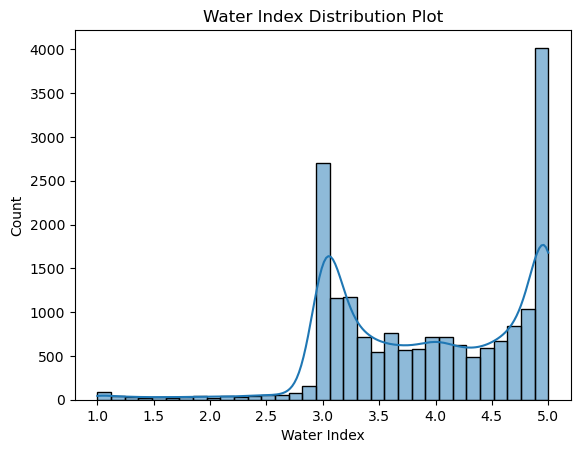

In [8]:
sns.histplot(data = train, x= "water_index", kde=True)
plt.title("Water Index Distribution Plot")
plt.xlabel("Water Index")
plt.ylabel("Count")

**Latitide and Longitude**

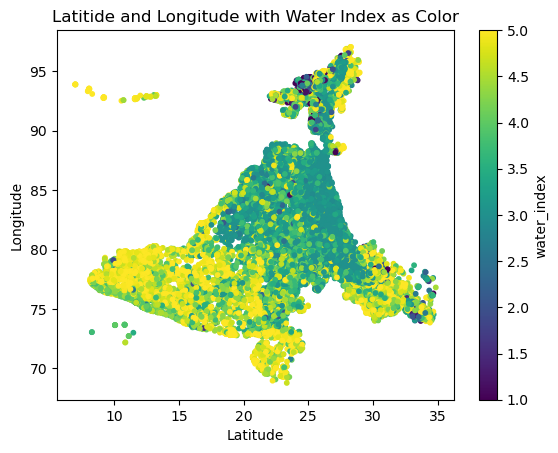

In [9]:
train.plot.scatter(x='lat', y='lon', c='water_index',colormap='viridis', s=10)
plt.title("Latitide and Longitude with Water Index as Color")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Urban or Rural

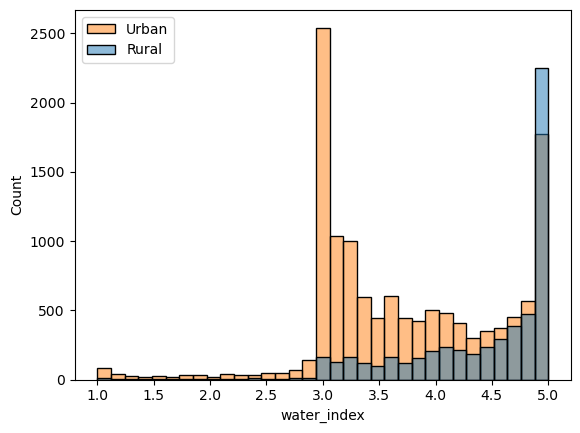

In [10]:
sns.histplot(data = train, x= "water_index",hue = "urban")
plt.legend(['Urban', 'Rural'], loc = 'upper left')
plt.show()

**Number of Houses**

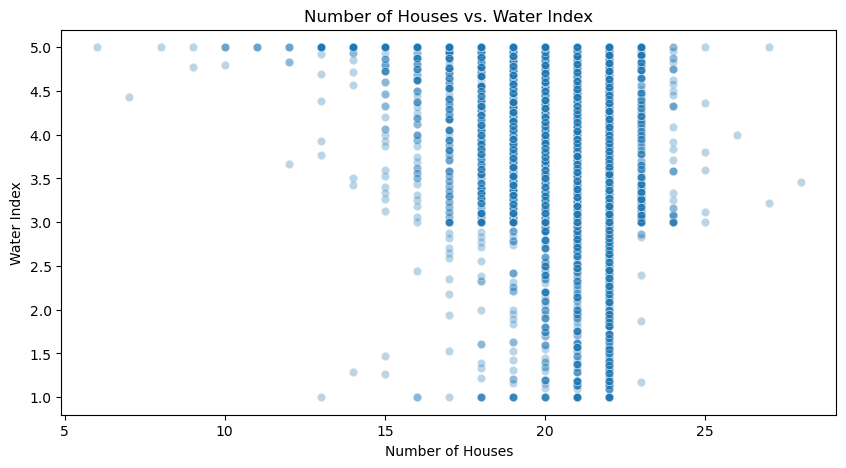

In [11]:
fig = plt.figure(figsize = (10,5))

sns.scatterplot(data = train, x="n_asset", y="water_index", alpha = 0.3)
plt.title("Number of Houses vs. Water Index")
plt.xlabel("Number of Houses")
plt.ylabel("Water Index")
fig.show()

**Asset Index**

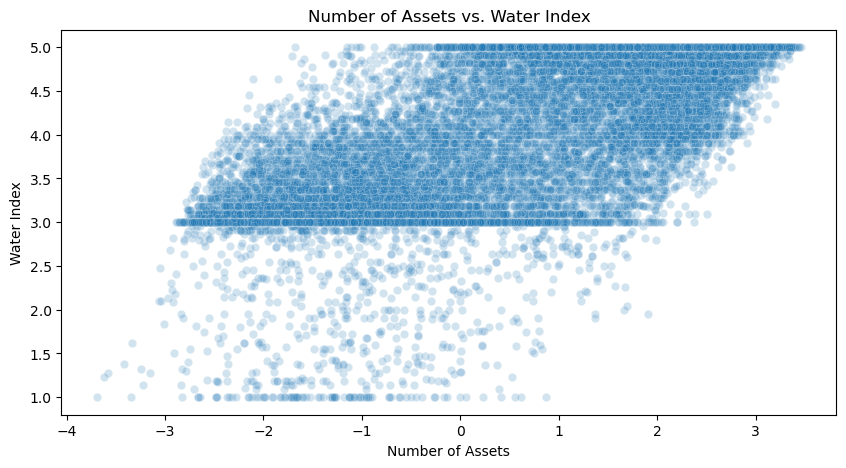

In [12]:
fig = plt.figure(figsize = (10,5))

sns.scatterplot(data = train, x="asset_index", y="water_index", alpha = 0.2)
plt.title("Number of Assets vs. Water Index")
plt.xlabel("Number of Assets")
plt.ylabel("Water Index")
fig.show()

**Area Code**

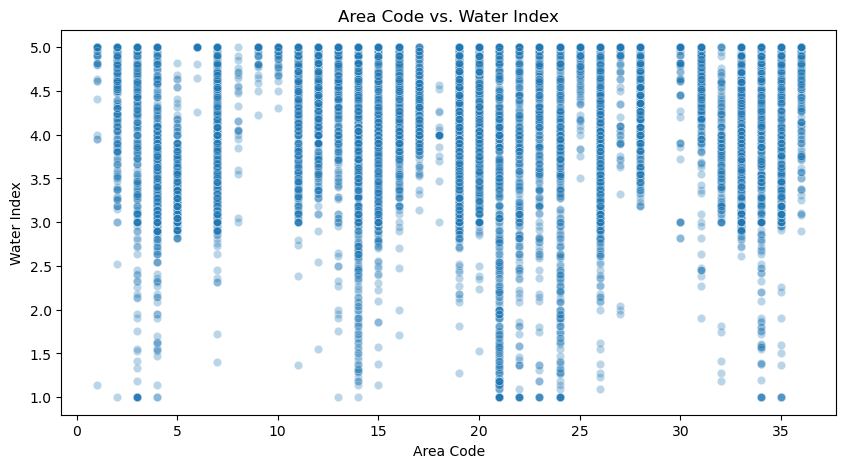

In [13]:
fig = plt.figure(figsize = (10,5))

sns.scatterplot(data = train, x="adm1dhs", y="water_index", alpha = 0.3)
plt.title("Area Code vs. Water Index")
plt.xlabel("Area Code")
plt.ylabel("Water Index")
fig.show()

**Satelite Image**

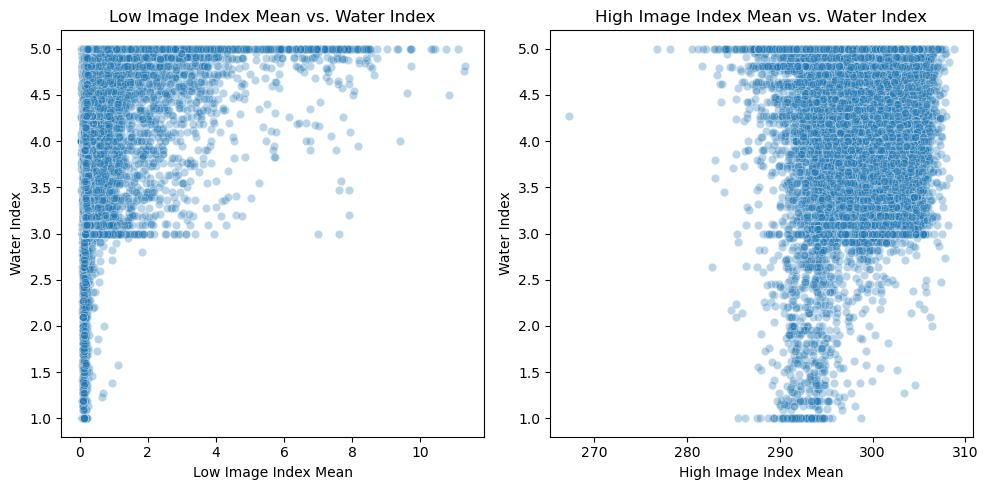

In [14]:
fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(1,2,1)
sns.scatterplot(data = train, x="image_mean_low", y="water_index", alpha = 0.3, axes = ax)
plt.title("Low Image Index Mean vs. Water Index")
plt.xlabel("Low Image Index Mean")
plt.ylabel("Water Index")

ax = fig.add_subplot(1,2,2)
sns.scatterplot(data = train, x="image_mean_high", y="water_index", alpha = 0.3, axes = ax)
plt.title("High Image Index Mean vs. Water Index")
plt.xlabel("High Image Index Mean")
plt.ylabel("Water Index")

plt.tight_layout()
plt.show()

## Skewness

In [15]:
print("Train Data \n{}".format(train.skew()))
print("Test Data \n{}".format(test.skew()))

Train Data 
year               0.000000
lat               -0.748020
lon                0.635526
n_asset           -2.164055
asset_index       -0.145823
n_water           -2.164055
water_index       -0.413674
cluster_id        -0.094380
adm1dhs           -0.101044
urban             -0.854880
image_mean_low     4.462592
image_mean_high   -0.654746
dtype: float64
Test Data 
year               0.000000
lat               -0.765689
lon                0.622388
n_asset           -2.454111
asset_index       -0.150131
cluster_id        -0.097605
adm1dhs           -0.103350
urban             -0.901763
image_mean_low     4.332274
image_mean_high   -0.722176
dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Deal with skewness

In [16]:
train["lat"] = train["lat"]**2
train["lon"] = np.log(train["lon"])
train["image_mean_low"] = np.log(train["image_mean_low"])**2

test["lat"] = test["lat"]**2
test["lon"] = np.log(test["lon"])
test["image_mean_low"] = np.log(test["image_mean_low"])**2

print("Train Data \n{}".format(train.skew()))
print("Test Data \n{}".format(test.skew()))

Train Data 
year               0.000000
lat               -0.095658
lon                0.518985
n_asset           -2.164055
asset_index       -0.145823
n_water           -2.164055
water_index       -0.413674
cluster_id        -0.094380
adm1dhs           -0.101044
urban             -0.854880
image_mean_low     0.377406
image_mean_high   -0.654746
dtype: float64
Test Data 
year               0.000000
lat               -0.109855
lon                0.504849
n_asset           -2.454111
asset_index       -0.150131
cluster_id        -0.097605
adm1dhs           -0.103350
urban             -0.901763
image_mean_low     0.329028
image_mean_high   -0.722176
dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.


## Model Selection

In [17]:
seed = 8888
rfg = RandomForestRegressor(random_state = seed)
etr = ExtraTreesRegressor(random_state = seed)
gbr = GradientBoostingRegressor(random_state = seed)
svr = SVR()
xgb = XGBRegressor(random_state = seed)
knn = KNeighborsRegressor()
rcv = RidgeCV()
enet = ElasticNet()
sgd = SGDRegressor()
br = BayesianRidge()
cbr = CatBoostRegressor(random_state = seed, verbose = False)

### Predictor Selection

In [18]:
# Uncomment to do predictor selection
# y_train = train["water_index"]

# scaler = RobustScaler()
# voting_reg = VotingRegressor(estimators=[('Random Forests', rfg), ('Extra Trees', etr), ('GBoost', gbr), ('SVR', svr), ('XGBoost', xgb)],
#                              n_jobs = -1, verbose = False)

# possible_predictors = ["lat", "lon", "n_asset", "asset_index", "adm1dhs","urban", "image_mean_low", "image_mean_high"]
# dataframe_columns = []
# best_score = [-1000000]

# i = 1
# for column in possible_predictors:
#     print("Checking : ",column)
#     dataframe = pd.DataFrame({column : train[column]})
#     for next_column in possible_predictors[i:]:
#         print("Checking:", next_column)
#         dataframe[next_column] = train[next_column]
        
#         pred_select_columns = dataframe.columns
#         pred_select_x = scaler.fit_transform(dataframe)
#         pred_select_x = pd.DataFrame(pred_select_x)
#         pred_select_x.columns = pred_select_columns
        
#         score = cross_val_score(voting_reg, pred_select_x, y_train, cv=5,n_jobs = -1, verbose = True, scoring="neg_root_mean_squared_error")
        
#         best_score.append(score)
            
#         name = ""
#         for column in pred_select_columns:
#             name = name + " + " + column
            
#         dataframe_columns.append(name)
#     i+=1
        
# param_selection = pd.DataFrame({"predictors" : dataframe_columns, "score" : best_score[1:]})

# for i,scores in enumerate(param_selection["score"]):
#     print("Mean of %s: %0.3f std: (+/- %0.3f) [%s] \n" % (param_selection["predictors"][i],scores.mean(), scores.std(), "Ensemble"))

In [19]:
predictors = ["lat", "lon", "asset_index", "adm1dhs","urban", 
              "image_mean_low", "image_mean_high"]
X_train = train[predictors]
X_test = test[predictors]
columns = X_train.columns
scaler = RobustScaler()
X_train_scaled = scaler.fit(X_train).transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

X_train.columns = columns
X_test.columns = columns
y_train = train["water_index"]

### Test Base Model

In [20]:
# Uncomment to test base model
# reg_array = [rfg,etr,knn,gbr,rcv,enet,sgd,svr,br,cbr,xgb]
# for reg in reg_array:
#     vanilla_scores = cross_val_score(reg, X_train, y_train, cv=10, n_jobs=-1, scoring = "neg_root_mean_squared_error")
#     print ("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(reg.__class__.__name__,vanilla_scores.mean(), vanilla_scores.std()))

Most Recent Run :
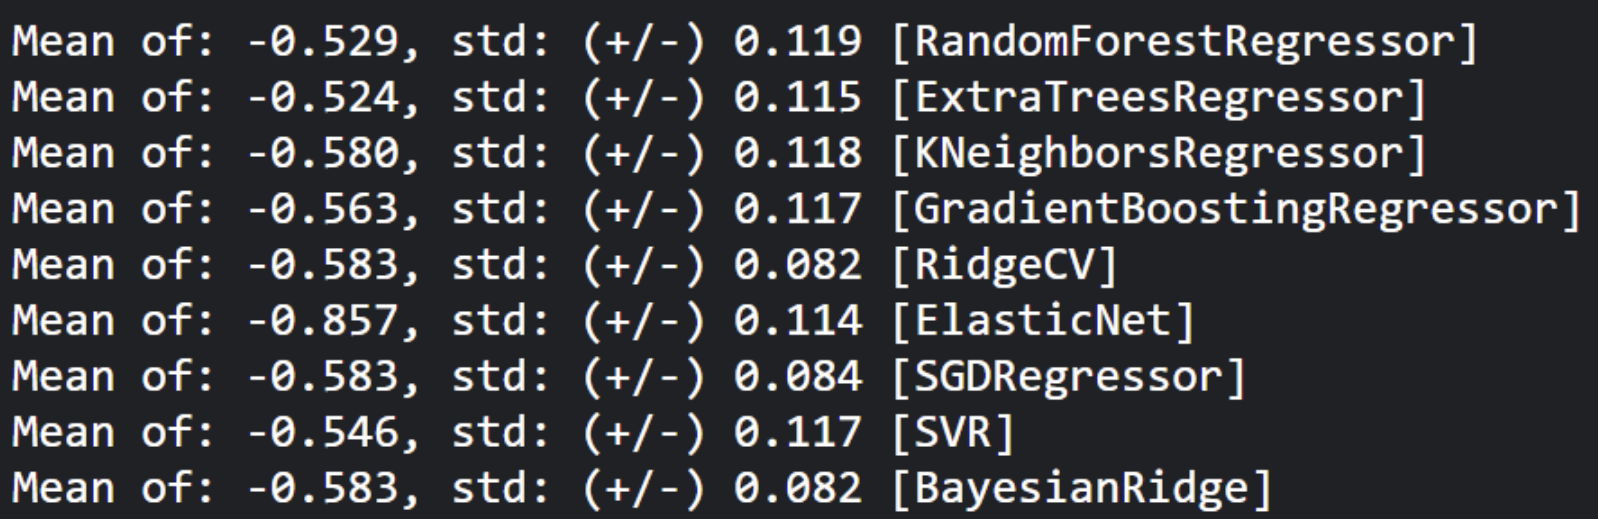
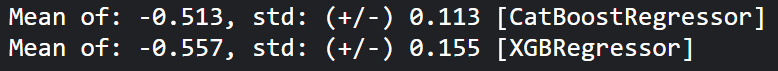

## Ensemble Models

### Stacking

In [21]:
# Uncomment to test cross validation on Stacking Model

# reg_array = [('Random Forests', rfg), ('Extra Trees', etr), ('GBoost', gbr), ('XGBoost', xgb), ('SVR', svr)]

# e_reg = StackingRegressor(estimators=reg_array)
# scores = cross_val_score(e_reg, X_train, y_train, cv=10, scoring="neg_root_mean_squared_error")
# print("Mean of: %0.2f std: (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), "Ensemble"))

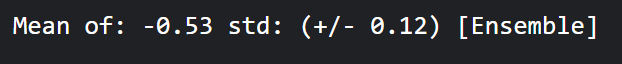

### Voting

In [22]:
# Uncomment to test cross validation on Voting Model
# reg_array = [('Random Forests', rfg), ('Extra Trees', etr), ('GBoost', gbr), ('SVR', svr), 
#                ('XGBoost', xgb), ('K Neighbors', knn), ('CatBoost', cbr)]

# e_reg = VotingRegressor(estimators=reg_array,
#                        n_jobs = -1, verbose = False)
# scores = cross_val_score(e_reg, X_train, y_train, cv=10,n_jobs = -1, scoring="neg_root_mean_squared_error")
# print("Mean of: %0.3f std: (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), "Ensemble"))

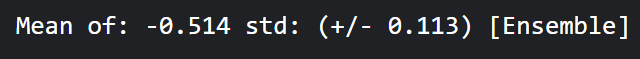

#### Voting Model Hyperparameter Selection

In [23]:
# Uncomment to do Voting hyperparameter selection

# voting = VotingRegressor(estimators=[('Random Forests', rfg), ('Extra Trees', etr), ('CatBoost', cbr)],
#                        n_jobs = -1, verbose = False)

# # params = {"weights" : [(1,1,1), (1,1,5), (1,1,9), (1,5,1), (1,5,5), (1,5,9), (1,9,1), (1,9,5),
# #                        (1,9,9), (5,1,1), (5,1,5), (5,1,9), (5,5,1), (5,5,5), (5,5,9), (5,9,1),
# #                        (5,9,5), (5,9,9), (9,1,1), (9,1,5), (9,1,9), (9,5,1), (9,5,5), (9,5,9),
# #                        (9,9,1), (9,9,5), (9,9,9)]}
# # Best -> (1,9,9)

# # params = {'weights': [(1,9,9), (1,9,13), (1,13,9), (1,13,13), (3,9,13), (3,13,9), (3,13,13),
# #                       (1,9,15), (1,15,9), (1,13,15), (1,15,13), (1,15,15)]}
# # Best -> (1,13,15)

# # params = {'weights' : [(1,13,15), (1,13,17), (1,13,20), (1,17,17), (1,17,20), (1,20,20), (1,20,17),
# #                        (1,13,25), (1,15,25), (1,20,25), (2,13,30), (1,20,30), (1,30,30)]}
# # Best -> (1,13,15)

# model = GridSearchCV(voting, params, n_jobs = -1, verbose =2, cv=5, scoring = "neg_root_mean_squared_error")
# model.fit(X_train, y_train)
# print(model.best_score_)
# print(model.best_params_)

## Final Best Model

In [24]:
voting_model = VotingRegressor(estimators=[('Random Forests', rfg), ('Extra Trees', etr), ('CatBoost', cbr)],
                                           n_jobs = -1,weights = [1, 13, 15], verbose = False)

best_model = voting_model

In [25]:
best_model.fit(X_train, y_train)

VotingRegressor(estimators=[('Random Forests',
                             RandomForestRegressor(random_state=8888)),
                            ('Extra Trees',
                             ExtraTreesRegressor(random_state=8888)),
                            ('CatBoost',
                             <catboost.core.CatBoostRegressor object at 0x7273e44c9fd0>)],
                n_jobs=-1, weights=[1, 13, 15])

In [26]:
y_test = best_model.predict(X_test)

print(y_test)

[5.01410668 4.95457779 4.62052849 ... 4.87662033 4.37719036 4.4031742 ]


In [27]:
test_id = test["DHSID_EA"].values

y_test = pd.DataFrame({"DHSID_EA" : test_id, "water_index" : y_test})

In [28]:
# Changing all numbers above 5 to be 5
y_test['water_index'].mask(y_test['water_index'] > 5, 5, inplace=True)

#### Save to csv

In [29]:
y_test.to_csv('mycsvfile.csv',index=False)

In [30]:
y_test

,DHSID_EA,water_index
0,IA-2015-7-00010009,5.000000
1,IA-2015-7-00010011,4.954578
2,IA-2015-7-00010017,4.620528
3,IA-2015-7-00010044,4.708316
4,IA-2015-7-00010060,4.990937
...,...,...
2670,IA-2015-7-00360403,4.985620
2671,IA-2015-7-00360454,4.931217
2672,IA-2015-7-00360474,4.876620
2673,IA-2015-7-00360476,4.377190


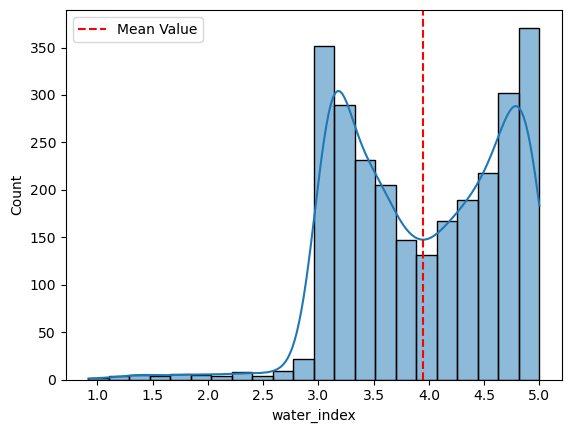

In [31]:
sns.histplot(data = y_test,x = 'water_index', kde=True)
mean = y_test['water_index'].mean()
plt.axvline(x =mean, color ="red",label = 'Mean Value', linestyle ="--")
plt.legend(loc ='upper left')

#### Comparison of y_train and y_test

In [32]:
print(y_train.max())
print(y_test["water_index"].max())
print(y_train.mean())
print(y_test["water_index"].mean())
print(y_train.min())
print(y_test["water_index"].min())

5.0
5.0
3.940415744361062
3.943055213152083
1.0
0.9185793872628514


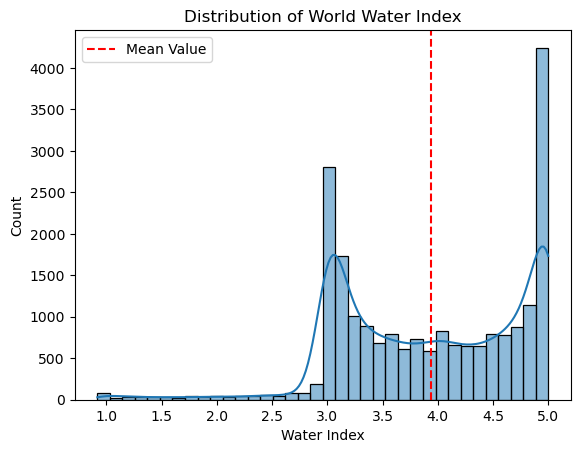

In [33]:
final = np.append(train['water_index'].values, y_test['water_index'].values)
df = pd.DataFrame({"Water Index" : final})
mean = df['Water Index'].values.mean()
sns.histplot(data = df,x = 'Water Index', kde=True)
plt.axvline(x =mean, color ="red",label = 'Mean Value', linestyle ="--")
plt.legend(loc ='upper left')
plt.title("Distribution of World Water Index")
plt.show()

## Finished, Yay! :)